In [5]:
import sys
from pathlib import Path

# Get project root
project_root = Path.cwd().parent

# Add to Python path
sys.path.insert(0, str(project_root))


In [35]:
from torch.utils.data import DataLoader
from pathlib import Path
from src.data.dataset import ISICSkinDataset
from src.data.transforms import train_transforms, val_transforms

project_root = Path.cwd().parent

train_dataset = ISICSkinDataset(
    csv_file=project_root / "data/processed/train/train_binary.csv",
    image_dir=project_root / "data/raw/train/images_train",
    transform=train_transforms
)

val_dataset = ISICSkinDataset(
    csv_file=project_root / "data/processed/val/val_binary.csv",
    image_dir=project_root / "data/raw/val/images_val",
    transform=val_transforms
)
#------------------------------------------------
from torch.utils.data import Subset

train_subset = Subset(train_dataset, range(500))

train_loader = DataLoader(
    train_subset,
    batch_size=4,
    shuffle=True,
    num_workers=0,
    pin_memory=False
)


val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0
)


In [36]:
images, labels = next(iter(train_loader))

print(images.shape)   # expected: (32, 3, 224, 224)
print(labels.shape)   # expected: (32,)
print(labels[:5])     # sanity check labels

torch.Size([4, 3, 224, 224])
torch.Size([4])
tensor([0, 1, 0, 0])


In [37]:
from torch.utils.data import DataLoader

debug_loader = DataLoader(
    train_dataset,
    batch_size=5,
    shuffle=False,   # IMPORTANT for verification
    num_workers=0
)


In [38]:
images, labels = next(iter(debug_loader))


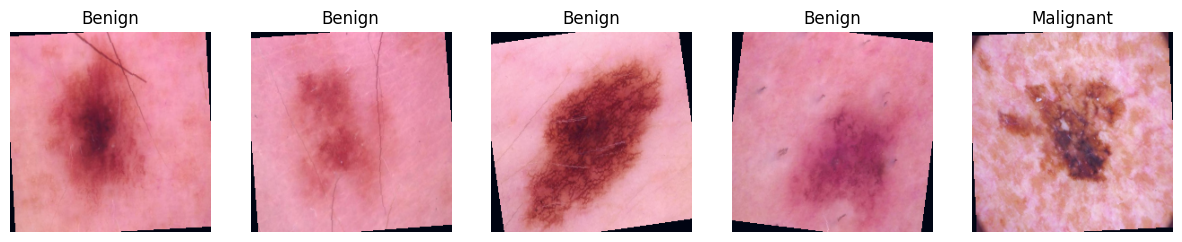

In [39]:
import matplotlib.pyplot as plt
import numpy as np

label_map = {0: "Benign", 1: "Malignant"}

plt.figure(figsize=(15, 4))

for i in range(len(images)):
    img = images[i].permute(1, 2, 0).numpy()   # CHW → HWC
    img = (img - img.min()) / (img.max() - img.min())  # normalize for display

    plt.subplot(1, len(images), i + 1)
    plt.imshow(img)
    plt.title(label_map[int(labels[i])])
    plt.axis("off")

plt.show()


ResNet-50 Setup (Model)

In [40]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)

# Replace final layer for binary classification
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

model = model.to(device)


In [41]:
# Replace final layer (1000 → 2)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# Move to device
model = model.to(device)

print(model.fc)

Linear(in_features=2048, out_features=2, bias=True)


In [42]:
images, labels = next(iter(train_loader))

images = images.to(device)
labels = labels.to(device)

outputs = model(images)

print("Output shape:", outputs.shape)
print("Sample logits:", outputs[:2])


Output shape: torch.Size([4, 2])
Sample logits: tensor([[ 0.1032, -0.0584],
        [ 0.1482, -0.1577]], grad_fn=<SliceBackward0>)


Phase-1 Training Logic

In [43]:
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

for param in model.fc.parameters():
    param.requires_grad = True



In [44]:
import torch.nn as nn

criterion = nn.CrossEntropyLoss()


In [45]:
import torch.optim as optim

optimizer = optim.Adam(
    model.fc.parameters(),
    lr=1e-3
)


In [46]:
model = model.to(device)


In [47]:
model.train()

for epoch in range(1):
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"Epoch {epoch}, Batch {i}, Loss: {loss.item():.4f}")


Epoch 0, Batch 0, Loss: 0.6441
Epoch 0, Batch 10, Loss: 1.1560
Epoch 0, Batch 20, Loss: 0.5726
Epoch 0, Batch 30, Loss: 0.4666
Epoch 0, Batch 40, Loss: 0.9401
Epoch 0, Batch 50, Loss: 0.4758
Epoch 0, Batch 60, Loss: 0.1945
Epoch 0, Batch 70, Loss: 0.2991
Epoch 0, Batch 80, Loss: 0.3523
Epoch 0, Batch 90, Loss: 0.7217
Epoch 0, Batch 100, Loss: 0.2163
Epoch 0, Batch 110, Loss: 0.2970
Epoch 0, Batch 120, Loss: 0.5311
